`python3 -m pip install -U pandas plotly nbformat`

`pip install "https://github.com/DCMLab/wavescapes/archive/refs/heads/johannes.zip"`

In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd

import pickle
from wavescapes import Wavescape
from wavescapes.color import circular_hue
import graphviz 
import statsmodels.formula.api as smf

from sklearn import metrics
from etl import get_dfts, get_human_analyses, get_mag_phase_mx, get_metadata, get_most_resonant, get_most_resonant_penta_dia, get_pcms, get_pcvs, test_dict_keys, \
  get_correlations, make_feature_vectors
from utils import get_coeff, most_resonant2color, long2utm, make_training_set, most_resonant_penta_dia


C:\Users\ludov\anaconda3\envs\ada\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\ludov\anaconda3\envs\ada\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


## Settings

In [2]:
DEBUSSY_REPO = '.'
DATA_FOLDER = '~/DATA/debussy_figures/data'
DATA_FOLDER = './data'
EXAMPLE_FNAME = 'l000_etude'
LONG_FORMAT = True

## Loading metadata
Metadata for all pieces contained in the dataset.

In [3]:
metadata = get_metadata(DEBUSSY_REPO)
metadata.columns

Metadata for 82 files.


Index(['rel_paths', 'last_mc', 'last_mn', 'length_qb', 'length_qb_unfolded',
       'all_notes_qb', 'n_onsets', 'TimeSig', 'KeySig', 'label_count',
       'composer', 'workTitle', 'movementNumber', 'movementTitle',
       'workNumber', 'poet', 'lyricist', 'arranger', 'copyright',
       'creationDate', 'mscVersion', 'platform', 'source', 'translator',
       'musescore', 'ambitus', 'comment', 'comments', 'composed_end',
       'composed_start', 'originalFormat', 'pdf', 'staff_1_ambitus',
       'staff_1_instrument', 'staff_2_ambitus', 'staff_2_instrument',
       'staff_3_ambitus', 'staff_3_instrument', 'transcriber', 'typesetter',
       'year', 'median_recording', 'qb_per_minute', 'sounding_notes_per_qb',
       'sounding_notes_per_minute'],
      dtype='object')

The column `year` contains composition years as the middle between beginning and end  of the composition span.

In [4]:
metadata.year.head(10)

fnames
l000_etude                     1915.0
l000_soirs                     1917.0
l009_danse                     1880.0
l066-01_arabesques_premiere    1888.0
l066-02_arabesques_deuxieme    1891.0
l067_mazurka                   1890.0
l068_reverie                   1890.0
l069_tarentelle                1890.0
l070_ballade                   1890.0
l071_valse                     1890.0
Name: year, dtype: float64

Series `median_recording` contains median recording times in seconds, retrieved from the Spotify API. the Spotify API.

In [5]:
metadata.median_recording.head(10)

fnames
l000_etude                     272.5530
l000_soirs                     145.8265
l009_danse                     124.5995
l066-01_arabesques_premiere    240.7780
l066-02_arabesques_deuxieme    213.9330
l067_mazurka                   175.9130
l068_reverie                   265.4265
l069_tarentelle                331.5290
l070_ballade                   396.0200
l071_valse                     221.4500
Name: median_recording, dtype: float64

Columns mirroring a piece's activity are currently:
* `qb_per_minute`: the pieces' lengths (expressed as 'qb' = quarterbeats) normalized by the median recording times; a proxy for the tempo
* `sounding_notes_per_minute`: the summed length of all notes normalized by the piece's duration (in minutes)
* `sounding_notes_per_qb`: the summed length of all notes normalized by the piece's length (in qb)
Other measures of activity could be, for example, 'onsets per beat/second' or 'distinct pitch classes per beat/second'.

## Loading human analysis data

In [6]:
analyses = get_human_analyses(DEBUSSY_REPO)
analyses.head()

,L,mc_start,mc_start_offset,mc_end,mc_end_offset,structure,transposition,comments,source,fname,from_qb,to_qb
0,70,4.0,0,6.0,0,octa,"1,2",NaN,Forte,l070_ballade,12.0,20.0
1,70,35.0,0,37.0,0,octa,"1,2",Eb odd note,Forte,l070_ballade,136.0,144.0
2,106,7.0,0,10.0,0,acoustic,A acoustic,NaN,Tymoczko,l106_isle,24.0,36.0
3,106,15.0,0,21.0,0,acoustic,A acoustic,NaN,Tymoczko,l106_isle,56.0,80.0
4,106,64.0,0,67.0,0,acoustic,A acoustic,NaN,Tymoczko,l106_isle,162.0,174.125


## Loading Pitch Class Vectors (PCVs)
An `{fname -> pd.DataFrame}` dictionary where each `(NX12)` DataFrame contains the absolute durations (expressed in quarter nots) of the 12 chromatic pitch classes for the `N` slices of length = 1 quarter note that make up the piece `fname`. The IntervalIndex reflects each slice's position in the piece. Set `pandas` to False to retrieve NumPy arrays without the IntervalIndex and column names.

In [7]:
pcvs = get_pcvs(DEBUSSY_REPO, pandas=True)
test_dict_keys(pcvs, metadata)
pcvs[EXAMPLE_FNAME].tail(5)

Found matrices for all files listed in metadata.tsv.


,0,1,2,3,4,5,6,7,8,9,10,11
iv,,,,,,,,,,,,
"[279.0, 280.0)",0.167,0.0,0.0,0.334,0.0,0.334,0.0,0.0,1.167,0.0,0.0,0.0
"[280.0, 281.0)",1.000,0.0,0.0,1.000,0.0,0.000,0.0,0.0,1.000,0.0,0.0,0.0
"[281.0, 282.0)",1.000,0.0,0.0,1.000,0.0,0.000,0.0,0.0,1.000,0.0,0.0,0.0
"[282.0, 283.0)",1.000,0.0,0.0,1.000,0.0,0.000,0.0,0.0,1.000,0.0,0.0,0.0
"[283.0, 284.0)",1.000,0.0,0.0,1.000,0.0,0.000,0.0,0.0,1.000,0.0,0.0,0.0


In [8]:
pcvs[EXAMPLE_FNAME].shape

(284, 12)

In [9]:
np.linalg.norm(pcvs[EXAMPLE_FNAME], axis=1).shape

norm = pcvs[EXAMPLE_FNAME].values / np.linalg.norm(pcvs[EXAMPLE_FNAME], axis=1).reshape(-1,1) 
norm.shape

(284, 12)

## Loading Pitch Class Matrices
An `{fname -> np.array}` dictionary where each `(NxNx12)` array contains the aggregated PCVs for all segments that make up a piece. The square matrices contain values only in the upper right triangle, with the lower left beneath the diagonal is filled with zeros. The values are arranged such that row 0 correponds to the original PCV, row 1 the aggregated PCVs for all segments of length = 2 quarter notes, etc. For getting the segment reaching from slice 3 to 5 (including), i.e. length 3, the coordinates are `(2, 5)` (think x = 'length - 1' and y = index of the last slice included). The following example shows the upper left 3x3 submatrix where the first three entries (which are PCVs of size 12) correspond to the first three PCVs above, the first three of the second row to their sums padded with a 0-PCV, and the first three of the third row corresponding to the sum of row 0, padded with another 0-PCV.

In [10]:
pcms = get_pcms(DEBUSSY_REPO, long=LONG_FORMAT)
test_dict_keys(pcms, metadata)
pcms[EXAMPLE_FNAME].shape

Found matrices for all files listed in metadata.tsv.


(40470, 12)

## Loading Discrete Fourier Transforms
`{fname -> np.array}` containing `(NxNx7)` complex matrices. For instance, here's the first element, a size 7 complex vector with DFT coefficients 0 through 6:

In [11]:
dfts = get_dfts(DEBUSSY_REPO, long=LONG_FORMAT)
test_dict_keys(dfts, metadata)
dfts[EXAMPLE_FNAME].shape

Found matrices for all files listed in metadata.tsv.


(40470, 7)

You can view the 7 complex numbers as magnitude-phase pairs

In [12]:
get_coeff(dfts[EXAMPLE_FNAME], 0, 0)

array([[ 2.  ,  0.  ],
       [ 1.05,  1.98],
       [ 1.36, -2.31],
       [ 1.38,  0.25],
       [ 1.04,  1.81],
       [ 1.69, -1.82],
       [ 1.33,  0.  ]])

or even as strings where the numbers are rounded and angles are shown in degrees:

In [13]:
get_coeff(dfts[EXAMPLE_FNAME], 0, 0, deg=True)

array([['2.0+0°'],
       ['1.05+247°'],
       ['1.36+132°'],
       ['1.38+346°'],
       ['1.04+256°'],
       ['1.69+104°'],
       ['1.33+0°']], dtype='<U9')

## Loading magnitude-phase matrices
`{fname -> np.array}` where each of the `(NxNx6x2)` matrices contains the 6 relevant DFT coefficients converted into magnitude-phase pairs where the magnitudes have undergone at least one normalization, i.e. are all within [0,1]. The files have been pre-computed and are loaded from g-zipped pickled matrices.

The parameter `norm_params` can be one or several `(how, indulge)` pairs where `indulge` is a boolean and `how ∈ {'0c', 'post_norm', 'max_weighted', 'max'}`.

In [14]:
norm_params = ('0c', True)
mag_phase_mx_dict = get_mag_phase_mx(DATA_FOLDER, norm_params=norm_params, long=True)
test_dict_keys(mag_phase_mx_dict, metadata)
mag_phase_mx_dict[EXAMPLE_FNAME].shape


Found matrices for all files listed in metadata.tsv.


(40470, 6, 2)

In [15]:
mpm = mag_phase_mx_dict[EXAMPLE_FNAME]
colors = circular_hue(mpm[...,1,:], output_rgba=True, ignore_phase=True)
colors.shape

(40470, 1)

In [16]:
circular_hue(long2utm(mpm[..., 1, :])).shape

(284, 284)

In [17]:
long2utm(colors)[...,0].shape

(284, 284)

Note that the phases (2nd column) are the same that we inspected above via `get_coeff()` whereas the magnitudes are now normalized by the first (now absent) coefficient 0.

In [18]:
mag_phase_mx_dict[EXAMPLE_FNAME][0]

array([[ 5.38214271e-01,  1.97790855e+00],
       [ 7.49750250e-01, -2.30792065e+00],
       [ 8.33166833e-01,  2.45331397e-01],
       [ 7.49750250e-01,  1.81282734e+00],
       [ 8.71880604e-01, -1.82039166e+00],
       [ 6.66333666e-01,  8.32251143e-17]])

## Loading most resonant DFT coefficients
This cell depends on the previously loaded magnitude-phase matrices, i.e. a conscious choice of a normalization method has been made above.

`get_most_resonant` returns three `{fname -> nd.array}` dictionaries where for each piece, the three `(NxN)` matrices correspond to

1. the index between 0 and 5 of the most resonant of the six DFT coefficient 1 through 6
2. its magnitude
3. the inverse entropy of the 6 magnitudes

In [19]:
max_coeffs, max_mags, inv_entropies = get_most_resonant(mag_phase_mx_dict, )
np.column_stack((max_coeffs[EXAMPLE_FNAME][:3],
max_mags[EXAMPLE_FNAME][:3],
inv_entropies[EXAMPLE_FNAME][:3]))

C:\Users\ludov\anaconda3\envs\ada\lib\site-packages\scipy\stats\_entropy.py:72: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


array([[4.        , 0.8718806 , 0.01330023],
       [3.        , 1.        , 0.07350712],
       [3.        , 1.        , 0.1796165 ]])

## Loading major, minor, and tritone correlations

This cell loads pickled matrices. To re-compute correlations from pitch-class matrices, use `get_maj_min_coeffs()` for major and minor correlations and `get_ttms()` for tritone-ness matrices.

In [20]:
correl_dict = get_correlations(DATA_FOLDER, long=LONG_FORMAT)
test_dict_keys(correl_dict, metadata)
correl_dict[EXAMPLE_FNAME].shape

Found matrices for all files listed in metadata.tsv.


(40470, 3)

## Loading pickled 9-fold vectors

The function is a shortcut for
* loading a particular kind of pickled normalized magnitude-phase-matrices
* loading pickled tritone, major, and minor coefficients
* concatenating them toegther

In [21]:
norm_params = ('0c', True)
ninefold_dict = make_feature_vectors(DATA_FOLDER, norm_params=norm_params, long=LONG_FORMAT)
test_dict_keys(ninefold_dict, metadata)
ninefold_dict[EXAMPLE_FNAME].shape

Found matrices for all files listed in metadata.tsv.


(40470, 9)

In [22]:
ninefold_dict[EXAMPLE_FNAME][10000]

array([0.04499069, 0.18518646, 0.21350191, 0.28154504, 0.23713982,
       0.10590321, 0.63039366, 0.50846798, 0.2189223 ])

### Merging analyses with 9-fold vectors

In [23]:
#analyses = get_human_analyses(DEBUSSY_REPO)
analyses_meta = analyses.merge(metadata, left_on='fname', right_index=True, how='left')
analyses_meta = analyses_meta[analyses_meta['from_qb'].notnull() & analyses_meta['to_qb'].notnull()].reset_index()
print(analyses_meta.shape)
analyses_meta.head(5)

(181, 58)


,index,L,mc_start,mc_start_offset,mc_end,mc_end_offset,structure,transposition,comments_x,source_x,...,staff_2_instrument,staff_3_ambitus,staff_3_instrument,transcriber,typesetter,year,median_recording,qb_per_minute,sounding_notes_per_qb,sounding_notes_per_minute
0,0,70,4.0,0,6.0,0,octa,"1,2",NaN,Forte,...,Piano,NaN,NaN,NaN,https://musescore.com/user/3797871,1890.0,396.020,63.633150,5.109714,325.147215
1,1,70,35.0,0,37.0,0,octa,"1,2",Eb odd note,Forte,...,Piano,NaN,NaN,NaN,https://musescore.com/user/3797871,1890.0,396.020,63.633150,5.109714,325.147215
2,2,106,7.0,0,10.0,0,acoustic,A acoustic,NaN,Tymoczko,...,Piano,NaN,NaN,NaN,https://musescore.com/user/31759,1904.0,355.413,77.360704,4.078298,315.499996
3,3,106,15.0,0,21.0,0,acoustic,A acoustic,NaN,Tymoczko,...,Piano,NaN,NaN,NaN,https://musescore.com/user/31759,1904.0,355.413,77.360704,4.078298,315.499996
4,4,106,64.0,0,67.0,0,acoustic,A acoustic,NaN,Tymoczko,...,Piano,NaN,NaN,NaN,https://musescore.com/user/31759,1904.0,355.413,77.360704,4.078298,315.499996


In [24]:
analyses_meta['structure'].value_counts()

octa              41
modal             35
wt                29
penta             26
majmin            17
acoustic          16
octa(?)            3
modal?             2
penta              2
majmin???          1
wt + penta         1
octa?              1
penta?             1
wt(?)              1
penta + majmin     1
Name: structure, dtype: int64

In [25]:
analyses_meta[analyses_meta['structure'].isin(['majmin', 'dia'])].shape

(17, 58)

In [26]:
extend = False
ground_truth_train = make_training_set(analyses_meta, ninefold_dict, extend=extend, pcms=pcms)
print(ground_truth_train.shape)
ground_truth_train.head()

(40020, 16)


,fname,coeff1,coeff2,coeff3,coeff4,coeff5,coeff6,major,minor,tritone,point,structure,diatonic,pentatonic,octatonic,wholetone
0,l070_ballade,0.123856,0.499969,0.333125,0.875148,0.295393,0.312504,0.607835,0.382270,0.582395,2519,octa,0,0,1,0
1,l070_ballade,0.162312,0.454512,0.030083,0.818413,0.266480,0.363628,0.276816,0.457584,0.660809,2105,octa,0,0,1,0
2,l070_ballade,0.127374,0.547558,0.475864,1.000000,0.310125,0.333333,0.645134,0.389931,0.490872,2104,octa,0,0,1,0
3,l070_ballade,0.264828,0.499917,0.777778,0.667166,0.705278,0.333333,0.644135,0.696061,0.021810,1690,octa,0,0,1,0
4,l070_ballade,0.190131,0.518436,0.184807,1.000000,0.181472,0.407375,0.365933,0.305899,0.646212,1689,octa,0,0,1,0


In [27]:
remove = []

for i, group in ground_truth_train.round(2).groupby(['fname','coeff1', 'coeff2', 'coeff3', 'coeff4', 'coeff5', 'coeff6', 'major', 'minor', 'tritone']):
    if len(group) > 1:
        if group['structure'].nunique() > 1:
            print(i, group)
            remove.append(list(group.index))

('l111-01_images_cloches', 0.27, 0.46, 0.36, 0.55, 0.8, 0.2, 0.78, 0.69, 0.02)                         fname  coeff1  coeff2  coeff3  coeff4  coeff5  coeff6  \
31101  l111-01_images_cloches    0.27    0.46    0.36    0.55     0.8     0.2   
32340  l111-01_images_cloches    0.27    0.46    0.36    0.55     0.8     0.2   

       major  minor  tritone  point structure  diatonic  pentatonic  \
31101   0.78   0.69     0.02    637    majmin         1           0   
32340   0.78   0.69     0.02    633        wt         0           0   

       octatonic  wholetone  
31101          0          0  
32340          0          1  
('l113-02_childrens_jimbos', 0.87, 0.5, 0.0, 1.0, 0.87, 1.0, 0.52, 0.53, 0.0)                           fname  coeff1  coeff2  coeff3  coeff4  coeff5  \
32656  l113-02_childrens_jimbos    0.87     0.5     0.0     1.0    0.87   
32658  l113-02_childrens_jimbos    0.87     0.5     0.0     1.0    0.87   
33566  l113-02_childrens_jimbos    0.87     0.5     0.0     1.0    0.8

In [28]:
remove = [r for rem in remove for r in rem]
len(remove)

660

In [49]:
ground_truth_train[ground_truth_train['structure'] == 'penta']['tritone'].median(), ground_truth_train[ground_truth_train['structure'] == 'penta']['tritone'].std(),  ground_truth_train[ground_truth_train['structure'] == 'penta']['major'].median(), ground_truth_train[ground_truth_train['structure'] == 'penta']['minor'].median()  

(0.020050861470179974,
 0.06937700201277856,
 0.7178529675169538,
 0.6072412849452147)

In [50]:
# major minor into one column
ground_truth_train[ground_truth_train['structure'] == 'majmin']['tritone'].median(), ground_truth_train[ground_truth_train['structure'] == 'majmin']['tritone'].std(), ground_truth_train[ground_truth_train['structure'] == 'majmin']['major'].median(), ground_truth_train[ground_truth_train['structure'] == 'majmin']['minor'].median()

(0.09519116228640634,
 0.09304896001108884,
 0.8338529288437128,
 0.5959229626990397)

In [31]:
ground_truth_train = ground_truth_train[~ground_truth_train.index.isin(remove)]

In [32]:
ground_truth_train.to_csv('full_groundtruth_train.csv')

In [33]:
mod = smf.logit(formula='diatonic ~ coeff1 + coeff2 + coeff3 + coeff4 + coeff6 + coeff5 + major + minor + tritone',
                data=ground_truth_train[ground_truth_train['structure'].isin(['penta', 'majmin'])])

res = mod.fit()
print(res.summary())


Optimization terminated successfully.
         Current function value: 0.185600
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:               diatonic   No. Observations:                32586
Model:                          Logit   Df Residuals:                    32576
Method:                           MLE   Df Model:                            9
Date:                Wed, 30 Mar 2022   Pseudo R-squ.:                  0.7305
Time:                        16:10:29   Log-Likelihood:                -6048.0
converged:                       True   LL-Null:                       -22445.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -22.9453      0.649    -35.356      0.000     -24.217     -21.673
coeff1        15.5127      0.

In [34]:
if extend:
    X_cols = ['coeff1', 'coeff2', 'coeff3', 'coeff4', 'coeff5', 'coeff6', 'major', 'minor', 'tritone', 0,1,2,3,4,5,6,7,8,9,10,11]
else:
    X_cols = ['coeff1', 'coeff2', 'coeff3', 'coeff4', 'coeff5', 'coeff6', 'major', 'minor', 'tritone']


In [35]:
penta_dia = ground_truth_train[ground_truth_train['structure'].isin(['penta', 'majmin'])]
mapper = {fname:val for val, fname in enumerate(penta_dia['fname'].unique())}

In [36]:
penta_dia['piece'] = penta_dia['fname'].apply(lambda x: mapper[x])
penta_dia.sample(5)

C:\Users\ludov\AppData\Local\Temp/ipykernel_20880/2044892555.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  penta_dia['piece'] = penta_dia['fname'].apply(lambda x: mapper[x])


,fname,coeff1,coeff2,coeff3,coeff4,coeff5,coeff6,major,minor,tritone,point,structure,diatonic,pentatonic,octatonic,wholetone,piece
13624,l100-01_estampes_pagode,0.118759,0.159044,0.208980,0.487778,0.705902,0.001341,0.740086,0.613318,0.029169,48988,penta,0,1,0,0,1
49821,l117-05_preludes_collines,0.238203,0.351351,0.549451,0.420693,0.622302,0.276920,0.828638,0.654339,0.086233,5239,majmin,1,0,0,0,7
27897,l100-01_estampes_pagode,0.210443,0.429167,0.241667,0.425000,0.786800,0.066667,0.841389,0.776558,0.036952,4785,penta,0,1,0,0,1
37728,l117-05_preludes_collines,0.114913,0.048556,0.210256,0.094928,0.470466,0.106900,0.918670,0.604521,0.200493,8056,majmin,1,0,0,0,7
19181,l100-01_estampes_pagode,0.082181,0.207737,0.214277,0.368350,0.747535,0.198034,0.761340,0.594157,0.013234,26416,penta,0,1,0,0,1


In [37]:
print(penta_dia.shape)
print(penta_dia['piece'].value_counts(), '\n', penta_dia['fname'].value_counts())

(32586, 17)
1    16779
7    14093
5      518
0      454
3      232
8      176
2      167
9       91
6       55
4       21
Name: piece, dtype: int64 
 l100-01_estampes_pagode      16779
l117-05_preludes_collines    14093
l113-02_childrens_jimbos       518
l106_isle                      454
l111-01_images_cloches         232
l123-05_preludes_bruyeres      176
l100-02_estampes_soiree        167
l123-09_preludes_hommage        91
l117-02_preludes_voiles         55
l111-02_images_lune             21
Name: fname, dtype: int64


In [38]:
X_train = penta_dia[penta_dia['piece'].isin([1, 7, 0, 3, 2, 5])][X_cols]
X_test = penta_dia[penta_dia['piece'].isin([6, 8, 9, 4])][X_cols]
y_test = penta_dia[penta_dia['piece'].isin([6, 8, 9, 4])]['diatonic']
y_train = penta_dia[penta_dia['piece'].isin([1, 7, 0, 3, 2, 5])]['diatonic']

X_train.shape, X_test.shape

((32243, 9), (343, 9))

In [39]:
y_test.value_counts(), y_train.value_counts()

(1    191
 0    152
 Name: diatonic, dtype: int64,
 0    17662
 1    14581
 Name: diatonic, dtype: int64)

In [40]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)

0.7142857142857143

In [41]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf = clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.641399416909621

In [47]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = 0.02  # step size in the mesh

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    make_pipeline(StandardScaler(), KNeighborsClassifier(3)),
    make_pipeline(StandardScaler(), SVC(kernel="linear", C=0.025)),
    make_pipeline(StandardScaler(), SVC(gamma=2, C=1)),
    make_pipeline(StandardScaler(), DecisionTreeClassifier(max_depth=5)),
    make_pipeline(StandardScaler(), RandomForestClassifier(max_depth=5, n_estimators=100, max_features=1)),
    make_pipeline(StandardScaler(), MLPClassifier(alpha=1, max_iter=1000)),
    make_pipeline(StandardScaler(), AdaBoostClassifier()),
    make_pipeline(StandardScaler(), GaussianNB()),
    make_pipeline(StandardScaler(), QuadraticDiscriminantAnalysis()),
]

In [48]:
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    y_pred = clf.predict(X_test)
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()

    print(name, score, 'confusion matrix', tn, fp, fn, tp)

Nearest Neighbors 0.6297376093294461 confusion matrix 54 98 29 162
Linear SVM 0.5510204081632653 confusion matrix 51 101 53 138
RBF SVM 0.6443148688046647 confusion matrix 98 54 68 123
Decision Tree 0.717201166180758 confusion matrix 100 52 45 146
Random Forest 0.7113702623906706 confusion matrix 69 83 16 175
Neural Net 0.7463556851311953 confusion matrix 86 66 21 170
AdaBoost 0.6151603498542274 confusion matrix 64 88 44 147
Naive Bayes 0.6618075801749271 confusion matrix 40 112 4 187
QDA 0.7842565597667639 confusion matrix 84 68 6 185


In [44]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]


In [45]:
clf = make_pipeline(StandardScaler(), QuadraticDiscriminantAnalysis())
clf.fit(X_train, y_train)
y_scores = clf.predict_proba(X_test)[:, 1]
y_pred_adj = adjusted_classes(y_scores, 0.9)
metrics.confusion_matrix(y_test, y_pred_adj)

array([[ 89,  63],
       [ 10, 181]], dtype=int64)

In [46]:
metrics.accuracy_score(y_test, y_pred_adj), metrics.accuracy_score(y_test, clf.predict(X_test)) 

(0.7871720116618076, 0.7842565597667639)

In [226]:
with open('model_penta_dia.pkl', 'wb') as outfile:
    pickle.dump(clf, outfile)

In [227]:
max_coeffs, max_mags, inv_entropies = get_most_resonant_penta_dia(mag_phase_mx_dict, ninefold_dict, clf)
np.column_stack((max_coeffs[EXAMPLE_FNAME][:3],
max_mags[EXAMPLE_FNAME][:3],
inv_entropies[EXAMPLE_FNAME][:3]))

C:\Users\ludov\anaconda3\envs\ada\lib\site-packages\scipy\stats\_entropy.py:72: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


array([[1.        , 1.        , 0.2969395 ],
       [1.        , 1.        , 0.2141454 ],
       [6.        , 0.8538459 , 0.28980569]])

## Minimal example for drawing a wavescape

Tight layout...


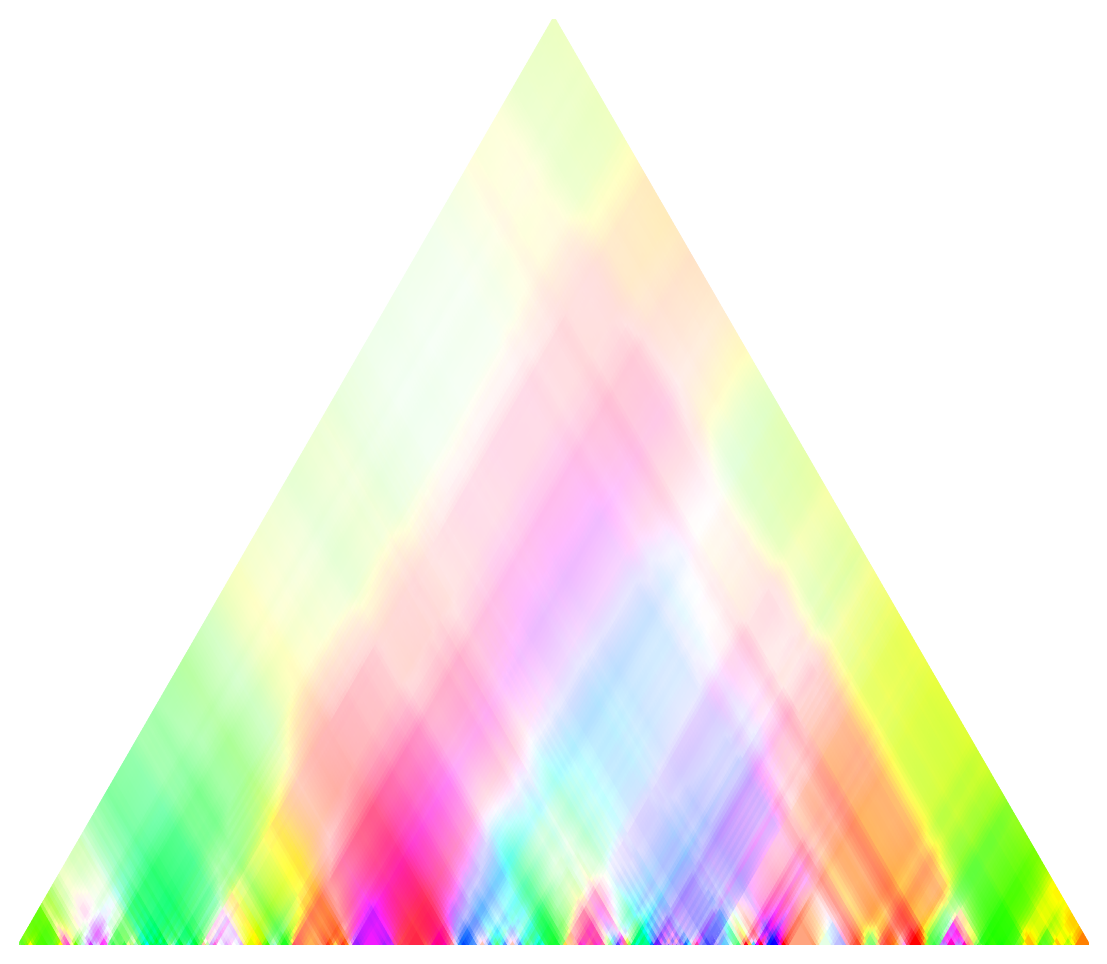

In [78]:
coeff_4_colors = circular_hue(mag_phase_mx_dict[EXAMPLE_FNAME][..., 3, :])
if LONG_FORMAT:
    coeff_4_colors = long2utm(coeff_4_colors)
length = coeff_4_colors.shape[0]
width = 500 if length <= 250 else 2 * length
ws = Wavescape(coeff_4_colors, width=width)
ws.draw()

## Drawing summary wavescapes and their associated color legend

Colour legend for most resonant coefficients:

![legend](legend.png)

In [232]:
EXAMPLE_FNAME = 'l117-02_preludes_voiles' #piece penta
EXAMPLE_FNAME = 'l100-01_estampes_pagode' #penta training
#EXAMPLE_FNAME = 'l117-05_preludes_collines' #dia training
#EXAMPLE_FNAME = 'l117-10_preludes_cathedrale' 
#EXAMPLE_FNAME = 'l075-01_suite_prelude' 

max_coeff, max_mag, inv_entropy = max_coeffs[EXAMPLE_FNAME], max_mags[EXAMPLE_FNAME], inv_entropies[EXAMPLE_FNAME]

if LONG_FORMAT:
    max_coeff, max_mag, inv_entropy = long2utm(max_coeff), long2utm(max_mag), long2utm(inv_entropy)

length = max_coeff.shape[0]
width = 500 if length <= 250 else 2 * length

draw_settings = dict(label_size=5, aw_per_tick=10, tick_factor=10) #tight_layout=False

Tight layout...


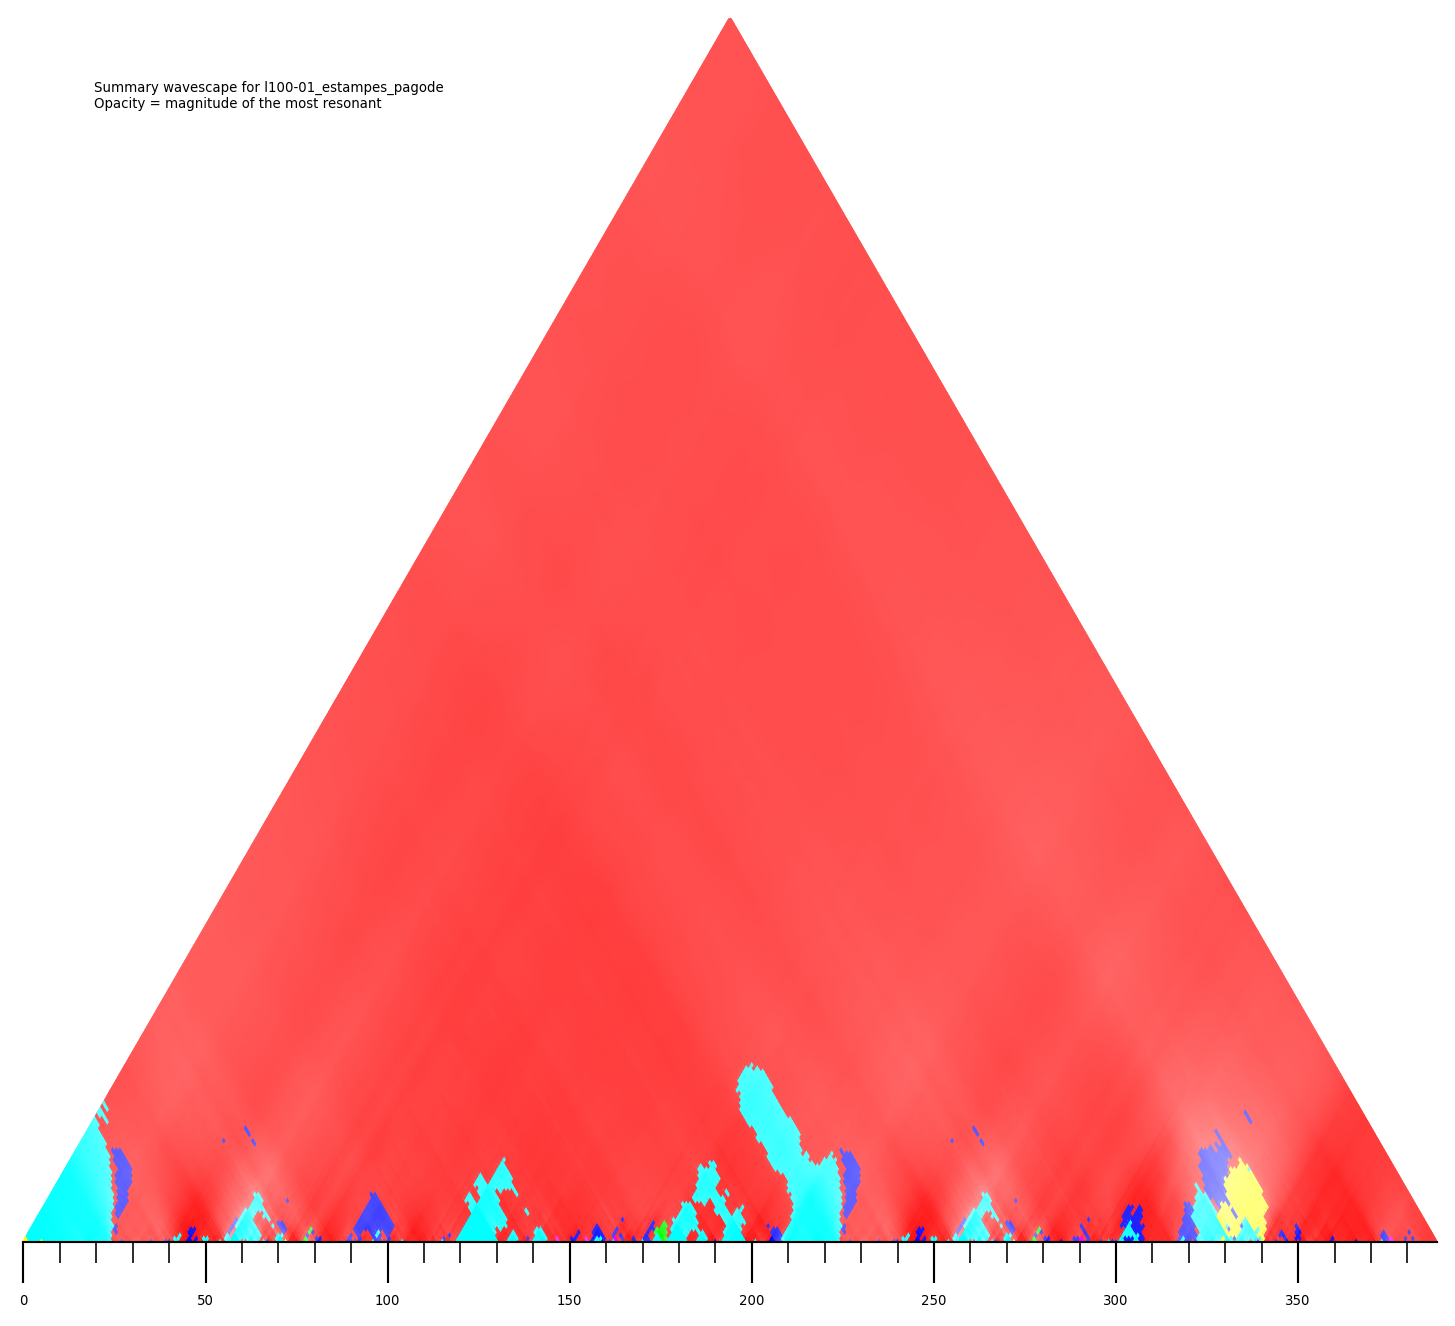

In [233]:
summary_by_max = most_resonant2color(max_coeff, max_mag)
ws = Wavescape(summary_by_max, width=width)
ws.draw(label=f"Summary wavescape for {EXAMPLE_FNAME}\nOpacity = magnitude of the most resonant", **draw_settings)

Tight layout...


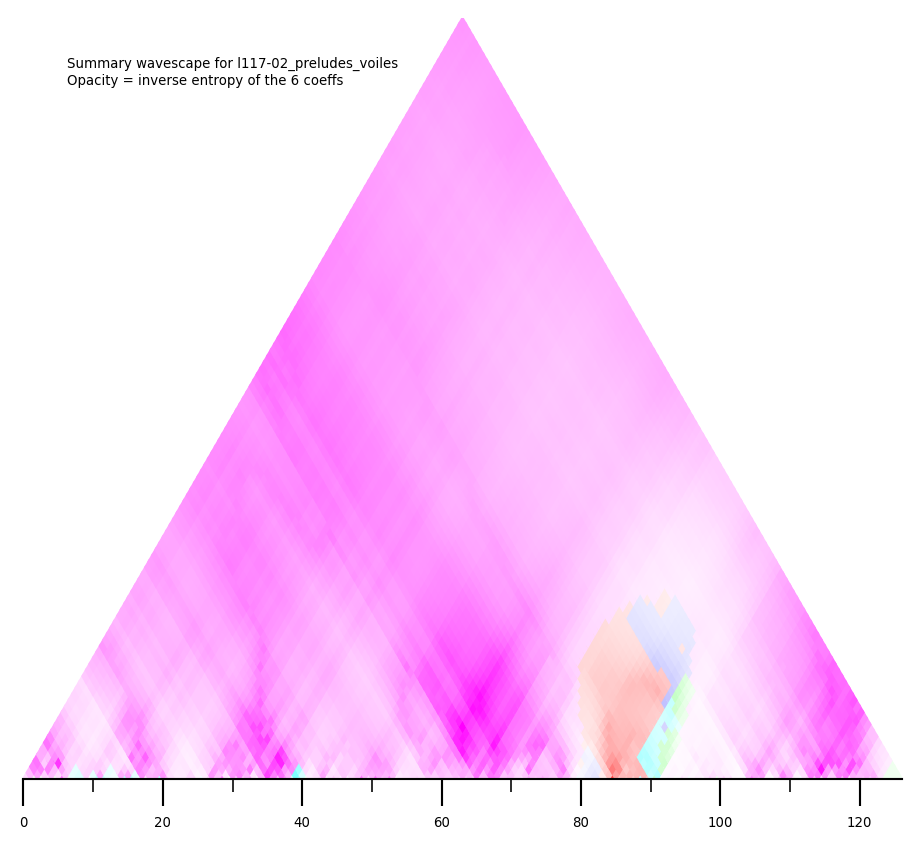

In [83]:
summaray_by_ent = most_resonant2color(max_coeff, inv_entropy)
ws = Wavescape(summaray_by_ent, width=width)
ws.draw(label=f"Summary wavescape for {EXAMPLE_FNAME}\nOpacity = inverse entropy of the 6 coeffs", **draw_settings)